# Overview

Cancer is one of the most ramp-it and devastating diseases in this world. One of the few things that humans can agree on, is everyone hates cancer. It is probably the biggest war that humanity has ever faced. Cancer has no empathy, and has no regard for pain and suffering. With that said, when I thought of what I wanted to do with my final project, I wanted to do something that mattered and had depth to it. When I learned that I could use image classification to determine if someone has a brain tumor, I jumped at the idea. My project in the grand scheme probably won't help cure cancer, but the fact that I can use neural networks and image classification, two of the most fascinating topics I have ever learned about, to work on a problem that is much greater than myself or this program was enough to get me pumped to start this project. In this project, I tackle a image classification problem that is idenifying if someone has a brain tumor or not. I attack this problem by building a convelusional neural network. After getting the model as accurate as possible, I will use the LIME library to evaluate why the model is making the prediction it is making. I will also talk about how this can be helpful in the world, and what would be the next few steps to continue this project.

# Buisness Problem

The buisness idea for this project, is to optomize Doctor's time by limiting the amount of MRI scans they have to look at. The idea is that someone comes in and gets a scan of their brain and it is immediately put through this model, and if the model believes they have a tumor, it will flag it for a doctor to look at, but if it is completely sure that they do not have a tumor then it will not require a doctor to look at it. Doing this greatly reduces the number of MRI scans that a doctor will have to look at. Allowing their precious time to be spent on something else. Bringing automation into a process like this does bring up a concern. The worst case senario is having the model predict someone doesn't have cancer when they actually do. In this context, that is a false negative. So it will be the upmost importance to reduce false negatives in this project.

# Data Understanding

The data that I used are MRI brain scans from Kaggle. In this data I have about 3,300 images, and originally the data had four classifications. There were three different types of tumors and then a no tumor classification. Since for this problem we only care if someone has a tumor or not, you will see below in the data preparation section I take the three different types of tumors and combine them into one category. This leaves us with two categories, "tumor" and "no tumor". This makes it a binary classification problem. After combining the those data points, I was left with a class imbalance of a lot more tumor images than no tumor images, and 3,300 also isn't the most data points. So with that said as you will see down in the modeling section, I use data augmentation to solve both of those. I go into more detail about data augmentation in the modeling section, but essentially it is both a good way to help me get more images as data and helps with the class imbalance. 

# Data Preparation

In this data preparation section, there is a lot of code below that is getting the data to the way I need it to be to run a neural network to work on it. There are lots of code comments along the way to help explain what the code is doing, but I will give a quick overview of what is going on in this section. The first part is just getting the data import and labeled correctly. After that I run a train test split on the data. I do it a second time to create a hold out set to test the model on at the end. I get the data in numerical categories instead of strign categories. I then finally as mentioned before get the data into just tumor or no tumor. Data augmentation should also get a call out here, even though I do it in the modeling section later, because that is a step I do with the data. It is a way to get more data and it is covered more in the modeling section.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from keras.models import load_model
from sklearn.metrics import confusion_matrix,recall_score, plot_confusion_matrix
filterwarnings('ignore')
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [3]:
# I got this code from Jay on kaggle, https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn
# code comment is mine
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
# Making a labels list to use it for a for loop to pull out the data.

In [4]:
# I got this code from Jay on kaggle, https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn
# the code comments are mine
X_train = []
y_train = []
# making empty lists
image_size = 150
# making the image size we want to be 150, so the images will be 150x150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Training',i)
    # this will give the path to each of the data folders inside of Training
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        # this is taking all the data and appending it to the X_train, and y_train lists we made.
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        # this is doing the same thing as the for loop above, but for the data under testing 
        # still appending it to the same training list, to put all the data together to run a train test split
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 79.30it/s]


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
# shuffling the data so we can get a new split in our train set split
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)
# creating a train test split
X_test, X_hold, y_test, y_hold = train_test_split(X_test, y_test, test_size=50, shuffle=False)
# creating a holdout set

In [6]:
y_train

array(['glioma_tumor', 'no_tumor', 'no_tumor', ..., 'meningioma_tumor',
       'pituitary_tumor', 'meningioma_tumor'], dtype='<U16')

In [7]:
# I got this code for y_train, and y_test from Jay on kaggle, y_hold is my code
# https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn
# The code comments are mine
# Taking the columns in y_train,y_test,y_hold, and making them categorical columns.
# This takes it from saying what type of tumor it is and makes each entry is a list of 4 numbers
# Depending on which number in the list is the "1" and not the "0" says which tumor it is, or if not a tumor
# An example of y_train before this is above and an example after is below
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

y_hold_new = []
for i in y_hold:
    y_hold_new.append(labels.index(i))
y_hold = y_hold_new
y_hold = tf.keras.utils.to_categorical(y_hold)

In [8]:
y_train

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

#### For our neural network we will be building, we are going to need a binary target. We will want it to just determine if there is a tumor or not a tumor. We do not care about the kind of tumor. Since we just wnat if tumor or not tumor, we are going to put combine all three kinds of tumors into one column that is just "tumor".

In [9]:
# This code below is getting the data in terms of tumor and no tumor

# Putting the data in y_train into a dataframe to work more easily with it
df_train = pd.DataFrame(y_train)
# Making a new column that is just "tumor" by adding the three tumor columns together
df_train['tumor'] = df_train[0] + df_train[2] + df_train[3]
# Renaming the column that repersents no tumor to be named "no tumor"
df_train = df_train.rename(columns = {1:'no_tumor'})
# dropping the columns for the three indiviual tumor columns, becasue we have the column that repersents if there is a tumor
# Do not need to know which indiviual tumor it is
df_train = df_train.drop(columns = [0,2,3])
# turning data back into a np array
y_train = df_train.to_numpy()

# Doing the same process as above but for y_test, and y_hold

df_test = pd.DataFrame(y_test)
df_test['tumor'] = df_test[0] + df_test[2] + df_test[3]
df_test = df_test.rename(columns = {1:'no_tumor'})
df_test = df_test.drop(columns = [0,2,3])
y_test = df_test.to_numpy()

df_hold = pd.DataFrame(y_hold)
df_hold['tumor'] = df_hold[0] + df_hold[2] + df_hold[3]
df_hold = df_hold.rename(columns = {1:'no_tumor'})
df_hold = df_hold.drop(columns = [0,2,3])
y_hold = df_hold.to_numpy()

# Modeling

The modeling process was done in a different notebook. The link to that notebook is https://www.kaggle.com/code/cooperthompson/brain-tumor-image-classification-problem. I am going to talk through the steps I took, but if you want to actually see the work it is in that notebook. 

The first model I made was just a basic neural network that had one middle hidden layer of 64 nodes. For every epoch it was producing the exact same accuracy. This was due to our class imbalance and so it was just predicting tumor everytime. Next we tried another basic neural network but with more hidden layers and dropout layers to see if this helps. It still just predicting tumor every single time. This was evidence that I was gonna have to run a convolutional neural network instead. 

The next steps was to try a CNN (convoluntional neural netwrok) with dropout layers, and one with kernel regularizer. Both dropout layers and kernel regularizer are different ways to fight overfitting. Both made the model better, and it is no longer just predicting tumor every time. The CNN model using kernel regularizer was the best model so far, so I moved forward with that. 

The next step was to try a few models with different amount of layers and different number of nodes to try and find the best combination. After trying alot of combinations and different things, I couldn't get it higher or get rid of overfitting completly. So I decided to bring in a pretrained model for the CNN. I used resnet-50 as my pretrained model. I brought it in and used all the optimal layers and nodes I had found. On top of that I went back and added data augmentation. This essentially takes all of the images and turns them 10 degress both directions and changes the brightness of the images to essentially create new images for the network to learn from. This is the process that lead to my final model.

In [19]:
# this is my final model that was made from the process listed above
final_model = load_model('../input/best-model-for-brain-tumor-classification/best_model_2.h5');

In [11]:
# this is a summary to show what the final model looks like
final_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_27 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)               6553728   
_________________________________________________________________
dense_90 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 65        
Total params: 30,149,761
Trainable params: 6,562,049
Non-trainable params: 23,587,712
_________________________________________________________________


# Evaluation

### Evaluating the numbers

Time to evaluate the final model. I am going to be evaluating it on accuracy and recall score. The accuracy is important becasue this is just how often it gets the prediction right versus when it gets it wrong. The recall score is also important becasue it is the score that represents the false negatives. If you have a high score in this that means you are reducing false negatives and that is important in this case becasue you don't want to tell someone they don't have a tumor when they actually do.

In [20]:
# This is showing how the final model did on the training data.
# It got 99.4% accuracy and 0.28 loss, and a recall score of 99.7%
print(final_model.evaluate(X_train,y_train[:,1]));
print(recall_score(y_train[:, 1],final_model.predict(X_train).round(0)))

92/92 [==============================] - 4s 33ms/step - loss: 0.2809 - accuracy: 0.9939
[0.28089502453804016, 0.99387127161026]
0.997588424437299


In [13]:
# This is showing how the final model did on the testing data.
# It got 98.5% accuracy and 0.33 loss, and a recall score of 99.1%
print(final_model.evaluate(X_test,y_test[:,1]))
print(recall_score(y_test[:, 1],final_model.predict(X_test).round(0)))

9/9 [==============================] - 0s 51ms/step - loss: 0.3311 - accuracy: 0.9856
[0.3311042785644531, 0.9855595827102661]
0.9914529914529915


In [14]:
# This is showing how the final model did on the holdout set data.
# It got 100% accuracy and 0.27 loss, and a recall of 100%
print(final_model.evaluate(X_hold,y_hold[:,1]))
print(recall_score(y_hold[:, 1],final_model.predict(X_hold).round(0)))

2/2 [==============================] - 0s 167ms/step - loss: 0.2715 - accuracy: 1.0000
[0.2715494930744171, 1.0]
1.0


### Evaluation with LIME

In this section, I will be using the LIME library to look at and evaluate what the neural network is thinking. LIME allows us to visualize the parts of the image that is leading the neural network to make its predictions. Below are 20 images from the holdout set, and as you can see there is green and red markings on them. Where you see green on the images that is the part of the image that it is using to help make a prediction that is a tumor, and where you see red is the part of the image that is making it think there isn't a tumor.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

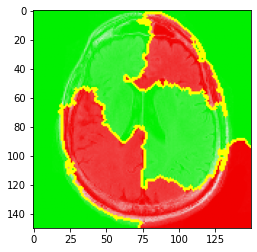

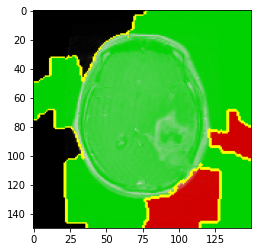

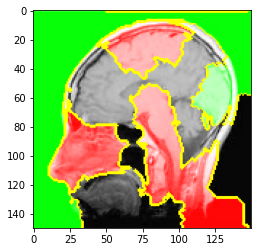

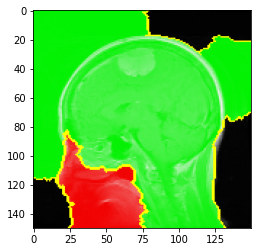

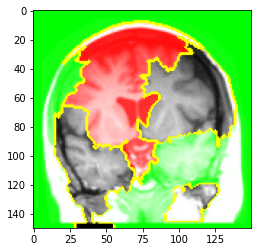

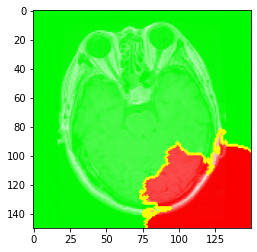

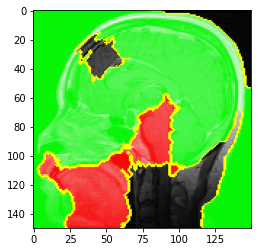

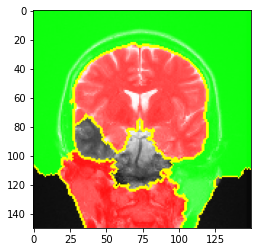

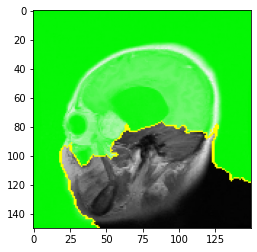

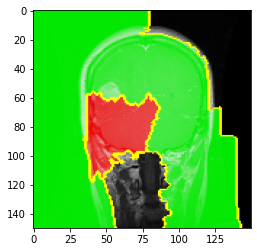

In [18]:
for index in list(range(0,10)):
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(X_hold[index], 
                                         final_model.predict,  
                                         labels=[0,1], hide_color=0, num_samples=1000)
    temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, ax2 = plt.subplots(figsize=(4,4))
    ax2.imshow(mark_boundaries(temp2, mask2));

There are a few take aways from these images. The first thing to remember is that the model got the prediction right on every single one of these. Which is kinda crazy becasue another take away is some of these images are wack and it seems like the neural network is all over the place, but in reality most of the ones it seems crazy on it was 99+% sure on them. This does bring up a good point though. Why is it learning from those random places or parts of the image that definitely shouldn't be learning from. For example, it is learning from the edges of the images that have nothing to do with the brain. This would definitely be a next step moving forward with this project. To try and figure out why it is learning from those random parts and how to limit that.

# Next Steps

Like I said above, an obvious next step would be to look into why the neural network is learning from parts of the image it shouldn't be learning from and to find ways to reduce that. Another good next step would be to do image localization and image segmentation. Image localization will put a box around where it thinks the tumor is, and image segmentation would actually outline exactly where it thinks the tumor is. This would be another way to draw the doctor's attention to that area and may even lead the doctor to see the tumor now when they wouldn't have before. Probably the best thing that can come from that is actaully just allow me to understand more what the model is thinking and might lead me to finding a better way to train the model. Another step moving forward which I believe to be the most important is thresholding. Right now the model has a threshold of 50%, which means if it thinks you have a 50+% chance of having a tumor it will predict tumor, but what this means is that if you have a 49% chance of having a tumor, it would say you don't have a tumor. This is not a great way to apply this model to the real world and definitely doesn't reduce false negatives like I said I wanted to do eariler. This would take a lot of testing to find the right number for the threshold to essentially eliminate all chances of false negatives.

# Conclusion

This model is incredibily accurate at predicting from an MRI brain scan if someone has a tumor or not. The parts of the image which it is learning from is a little peculiar and I would like to look into why it is doing that and how to reduce it learning from parts it shouldn't be. Also a very important step in this is that the model should not be put into pratice until the threshold has been looked at and studied to find the right number to reduce false negatives as much as humanly possible.